# Vector-to-Vector Network & Training

In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import collections
from collections import OrderedDict

## User Inputs

In [15]:
infile = 'vtov2_dataset.npz'
batch_size = 250
n_epochs = 500
hidden_layers = [(1,50)]
valid_size = 2000
model_path = 'vtov2_model_1'
fig_path = 'vtov2_fig_1.png'
fig2_path = 'vtov2_fig_2.png'
df_path = 'vtov2_df_1'
seed = np.random.randint(low=0, high=1000000, size=1)

## Loading Data

In [16]:
npfile = np.load(infile)
inputs = npfile['inputs']
outputs = npfile['outputs']

In [17]:
# standardizing inputs, outputs and coverting to tensors
inputMeans = inputs[0:int(inputs.shape[0]),:].mean(axis=0)
inputStdDevs = inputs[0:int(inputs.shape[0]),:].std(axis=0)
inputs = (inputs-inputMeans)/inputStdDevs
inputs = torch.from_numpy(inputs).float()

outputMeans = outputs[0:int(outputs.shape[0]),:].mean(axis=0)
outputStdDevs = outputs[0:int(outputs.shape[0]),:].std(axis=0)
outputs = (outputs-outputMeans)/outputStdDevs
outputs = torch.from_numpy(outputs).float()

In [18]:
# generating a TensorDataset for training
trainset = torch.utils.data.TensorDataset(inputs, outputs)

## Network Definition

In [19]:
# input, output sizes
out_size = list(outputs[0].size())[0]
in_size = list(inputs[0].size())[0]

# number of hidden layers
num = len(hidden_layers)

# number of nodes in a given hidden layer
def nodes(i):
    layer = hidden_layers[i]
    dim_node = layer[1]
    return dim_node

In [20]:
network = OrderedDict([])

network = OrderedDict([('lin1', nn.Linear(in_size, nodes(0))),('relu1', nn.ReLU())]) 
if num > 1:
    for i in range(1, num):
        network['lin{index}'.format(index=i+1)] = nn.Linear(nodes(i-1), nodes(i))
        network['relu{index}'.format(index=i+1)] = nn.ReLU()
network['lin{index}'.format(index=num+1)] = nn.Linear(nodes(num-1), out_size)    

model = nn.Sequential(network)

## Function Definitions

In [21]:
# defines the training process for one epoch, returns training loss for given epoch
def train(model, loader, optimizer, criterion):
    running_train_loss = 0.0

    # put model into train mode
    model.train()

    for batch_idx, (inputs, outputs) in enumerate(loader):
        inputs_var = inputs
        outputs_var = outputs
        
        # get model output & loss for each given input
        model_outputs = model(inputs_var)
        loss = criterion(model_outputs, outputs_var)

        # record cummulative loss
        running_train_loss += loss.item()

        # gradient, optimizer steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return running_train_loss


# defines the validation process for one epoch, returns validation loss for given epoch
def validate(model, loader, criterion):
    running_valid_loss = 0.0

    # put model in evaluation mode
    model.eval()

    for batch_idx, (inputs, outputs) in enumerate(loader):
        with torch.no_grad():
            inputs_var = inputs
            outputs_var = outputs

            # get model output & loss for each given input
            model_outputs = model(inputs_var)
            loss = criterion(model_outputs, outputs_var)

        # record cummulative loss
        running_valid_loss += loss.item()

    return running_valid_loss


# runs training and validation process over all epochs, returns results
def run_training(model, modelpath, figpath, fig2path, dfpath, trainset, validsize, numepochs, batchsize, seed):
    # set seed
    torch.manual_seed(seed)

    # create validation split
    indices = torch.randperm(len(trainset))
    train_indices = indices[:len(indices) - valid_size]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    valid_indices = indices[len(indices) - valid_size:]
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)

    # define data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
  
    # set criterion, optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    # store results
    best_model = copy.deepcopy(model.state_dict())
    train_loss_results = []
    valid_loss_results = []
    epochs = []
    
    # train model
    for epoch in enumerate(range(n_epochs)):
        trainloss = train(model=model,loader=train_loader,criterion=criterion,optimizer=optimizer)
        print('train loss for epoch {index} attained: {loss}'.format(index=epoch[0], loss=trainloss))
        
        validloss = validate(model=model,loader=valid_loader,criterion=criterion)
        print('valid loss for epoch {index} attained: {loss}'.format(index=epoch[0], loss=validloss))
        
        train_loss_results.append(trainloss)
        valid_loss_results.append(validloss)
        epochs.append(epoch[0]+1)
        
        # check if model is the best, save if best
        if epoch[0] == 0:
            bestloss = validloss

        if epoch[0] > 0:
            if validloss < bestloss:
                bestloss = validloss
                best_model = copy.deepcopy(model)
                best_epoch = epoch[0]
                print('new best model saved')
                
        print('epoch {index} done'.format(index=epoch[0]))
        
    print('finished looping epochs')
    print('best valid loss = {}, epoch {}'.format(bestloss, best_epoch))

    # load and save the best model
    torch.save(best_model, model_path)
    print('best model loaded and saved')

    # plot training & validation loss vs. epoch
    fig1 = plt.figure()
    plt.plot(epochs, train_loss_results)
    plt.plot(epochs, valid_loss_results)
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
    plt.title('Model Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    fig1.savefig(fig_path)
    print('plot saved')
    
    # plot training & validation loss vs. epoch -- scale 2
    fig2 = plt.figure()
    plt.plot(epochs, train_loss_results)
    plt.plot(epochs, valid_loss_results)
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
    plt.title('Model Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0,(bestloss*100))
    plt.show()
    fig2.savefig('fig2_path')
    print('plot saved')
    
    # create dataframe of epochs, losses
    d = {'trainloss':train_loss_results, 'validloss':valid_loss_results}
    df = pd.DataFrame(d, index=epochs)
    df.to_csv(df_path)
    print('dataframe saved')
    
    return

## Run Training Function

train loss for epoch 0 attained: 23.671279907226562
valid loss for epoch 0 attained: 4.431155323982239
epoch 0 done
train loss for epoch 1 attained: 14.916361004114151
valid loss for epoch 1 attained: 3.010825455188751
new best model saved
epoch 1 done
train loss for epoch 2 attained: 11.106350541114807
valid loss for epoch 2 attained: 2.43001851439476
new best model saved
epoch 2 done
train loss for epoch 3 attained: 9.370645582675934
valid loss for epoch 3 attained: 2.0862362533807755
new best model saved
epoch 3 done
train loss for epoch 4 attained: 8.028527542948723
valid loss for epoch 4 attained: 1.7616115659475327
new best model saved
epoch 4 done
train loss for epoch 5 attained: 6.653187811374664
valid loss for epoch 5 attained: 1.4233337342739105
new best model saved
epoch 5 done
train loss for epoch 6 attained: 5.251768380403519
valid loss for epoch 6 attained: 1.090660348534584
new best model saved
epoch 6 done
train loss for epoch 7 attained: 3.9036694020032883
valid loss f

train loss for epoch 58 attained: 0.06289150414522737
valid loss for epoch 58 attained: 0.01554007176309824
new best model saved
epoch 58 done
train loss for epoch 59 attained: 0.06075188843533397
valid loss for epoch 59 attained: 0.015023001935333014
new best model saved
epoch 59 done
train loss for epoch 60 attained: 0.05862009769771248
valid loss for epoch 60 attained: 0.014563119621016085
new best model saved
epoch 60 done
train loss for epoch 61 attained: 0.05685670825187117
valid loss for epoch 61 attained: 0.014108829782344401
new best model saved
epoch 61 done
train loss for epoch 62 attained: 0.055375245749019086
valid loss for epoch 62 attained: 0.013805265305563807
new best model saved
epoch 62 done
train loss for epoch 63 attained: 0.053541593602858484
valid loss for epoch 63 attained: 0.01330019417218864
new best model saved
epoch 63 done
train loss for epoch 64 attained: 0.051834813435561955
valid loss for epoch 64 attained: 0.012888049124740064
new best model saved
epoch

train loss for epoch 115 attained: 0.01603444089414552
valid loss for epoch 115 attained: 0.003965028910897672
new best model saved
epoch 115 done
train loss for epoch 116 attained: 0.015559855819446966
valid loss for epoch 116 attained: 0.003793681418756023
new best model saved
epoch 116 done
train loss for epoch 117 attained: 0.01503031060565263
valid loss for epoch 117 attained: 0.003678686131024733
new best model saved
epoch 117 done
train loss for epoch 118 attained: 0.014694691897602752
valid loss for epoch 118 attained: 0.003626818535849452
new best model saved
epoch 118 done
train loss for epoch 119 attained: 0.014401042164536193
valid loss for epoch 119 attained: 0.003534563584253192
new best model saved
epoch 119 done
train loss for epoch 120 attained: 0.013938774151029065
valid loss for epoch 120 attained: 0.003449526207987219
new best model saved
epoch 120 done
train loss for epoch 121 attained: 0.013655857124831527
valid loss for epoch 121 attained: 0.003369336191099137
ne

train loss for epoch 172 attained: 0.006951520263100974
valid loss for epoch 172 attained: 0.0017195510299643502
new best model saved
epoch 172 done
train loss for epoch 173 attained: 0.006977068886044435
valid loss for epoch 173 attained: 0.001731393378577195
epoch 173 done
train loss for epoch 174 attained: 0.006863330359919928
valid loss for epoch 174 attained: 0.001700763066764921
new best model saved
epoch 174 done
train loss for epoch 175 attained: 0.006812610736233182
valid loss for epoch 175 attained: 0.0016642567206872627
new best model saved
epoch 175 done
train loss for epoch 176 attained: 0.006715713039739057
valid loss for epoch 176 attained: 0.001651549042435363
new best model saved
epoch 176 done
train loss for epoch 177 attained: 0.006712075191899203
valid loss for epoch 177 attained: 0.0016696903185220435
epoch 177 done
train loss for epoch 178 attained: 0.006613638091948815
valid loss for epoch 178 attained: 0.001664903771597892
epoch 178 done
train loss for epoch 179

train loss for epoch 232 attained: 0.004545217234408483
valid loss for epoch 232 attained: 0.001209955065860413
epoch 232 done
train loss for epoch 233 attained: 0.004536980115517508
valid loss for epoch 233 attained: 0.0011906248546438292
epoch 233 done
train loss for epoch 234 attained: 0.004450267028005328
valid loss for epoch 234 attained: 0.0011440516536822543
new best model saved
epoch 234 done
train loss for epoch 235 attained: 0.00439500995707931
valid loss for epoch 235 attained: 0.0011218018917134032
new best model saved
epoch 235 done
train loss for epoch 236 attained: 0.004391515161842108
valid loss for epoch 236 attained: 0.0011419141810620204
epoch 236 done
train loss for epoch 237 attained: 0.004465477846679278
valid loss for epoch 237 attained: 0.0011059457901865244
new best model saved
epoch 237 done
train loss for epoch 238 attained: 0.004355256314738654
valid loss for epoch 238 attained: 0.0011361699871486053
epoch 238 done
train loss for epoch 239 attained: 0.004312

train loss for epoch 294 attained: 0.0036812965699937195
valid loss for epoch 294 attained: 0.0010097104532178491
epoch 294 done
train loss for epoch 295 attained: 0.003555608549504541
valid loss for epoch 295 attained: 0.0009595413066563196
epoch 295 done
train loss for epoch 296 attained: 0.003561023790098261
valid loss for epoch 296 attained: 0.0009473255122429691
new best model saved
epoch 296 done
train loss for epoch 297 attained: 0.0035997401719214395
valid loss for epoch 297 attained: 0.0009408424739376642
new best model saved
epoch 297 done
train loss for epoch 298 attained: 0.003566844512533862
valid loss for epoch 298 attained: 0.0010218565730610862
epoch 298 done
train loss for epoch 299 attained: 0.003630072016676422
valid loss for epoch 299 attained: 0.0009526206777081825
epoch 299 done
train loss for epoch 300 attained: 0.0035921387243433855
valid loss for epoch 300 attained: 0.0010224065190413967
epoch 300 done
train loss for epoch 301 attained: 0.003557479110895656
val

train loss for epoch 356 attained: 0.003256773699831683
valid loss for epoch 356 attained: 0.0008513498250977136
epoch 356 done
train loss for epoch 357 attained: 0.003237587006879039
valid loss for epoch 357 attained: 0.0008646291316836141
epoch 357 done
train loss for epoch 358 attained: 0.003210190945537761
valid loss for epoch 358 attained: 0.0009079408046090975
epoch 358 done
train loss for epoch 359 attained: 0.003248231085308362
valid loss for epoch 359 attained: 0.0008679790116730146
epoch 359 done
train loss for epoch 360 attained: 0.0033297059489996172
valid loss for epoch 360 attained: 0.0008710695401532575
epoch 360 done
train loss for epoch 361 attained: 0.003228133740776684
valid loss for epoch 361 attained: 0.0008733143622521311
epoch 361 done
train loss for epoch 362 attained: 0.00325354773667641
valid loss for epoch 362 attained: 0.0008623641479061916
epoch 362 done
train loss for epoch 363 attained: 0.003258238037233241
valid loss for epoch 363 attained: 0.00086287365

train loss for epoch 419 attained: 0.003063370764721185
valid loss for epoch 419 attained: 0.0008033378253458068
epoch 419 done
train loss for epoch 420 attained: 0.003036720991076436
valid loss for epoch 420 attained: 0.000791629652667325
epoch 420 done
train loss for epoch 421 attained: 0.002997192437760532
valid loss for epoch 421 attained: 0.0007805375353200361
epoch 421 done
train loss for epoch 422 attained: 0.0029580023838207126
valid loss for epoch 422 attained: 0.0007906543251010589
epoch 422 done
train loss for epoch 423 attained: 0.002960102428914979
valid loss for epoch 423 attained: 0.0007816413999535143
epoch 423 done
train loss for epoch 424 attained: 0.002964273589896038
valid loss for epoch 424 attained: 0.0007931786167318933
epoch 424 done
train loss for epoch 425 attained: 0.0029252300882944837
valid loss for epoch 425 attained: 0.0007924737728899345
epoch 425 done
train loss for epoch 426 attained: 0.0030096409827820025
valid loss for epoch 426 attained: 0.000826801

train loss for epoch 482 attained: 0.0028201727036503144
valid loss for epoch 482 attained: 0.0007238740072352812
epoch 482 done
train loss for epoch 483 attained: 0.0027501375079737045
valid loss for epoch 483 attained: 0.0007210492622107267
epoch 483 done
train loss for epoch 484 attained: 0.0027712786686606705
valid loss for epoch 484 attained: 0.000730902400391642
epoch 484 done
train loss for epoch 485 attained: 0.002810810452501755
valid loss for epoch 485 attained: 0.0007330947773880325
epoch 485 done
train loss for epoch 486 attained: 0.0028227570219314657
valid loss for epoch 486 attained: 0.0007353934852289967
epoch 486 done
train loss for epoch 487 attained: 0.002858413616195321
valid loss for epoch 487 attained: 0.0007323326426558197
epoch 487 done
train loss for epoch 488 attained: 0.0028001467435387895
valid loss for epoch 488 attained: 0.0007306467305170372
epoch 488 done
train loss for epoch 489 attained: 0.0028156330808997154
valid loss for epoch 489 attained: 0.000779

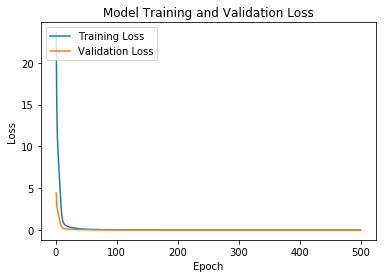

plot saved


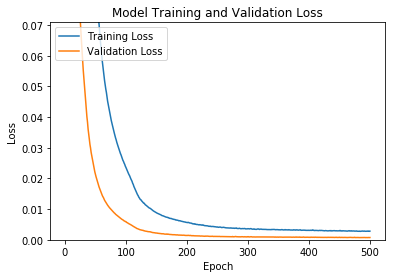

plot saved
dataframe saved
Finished!


In [22]:
# train the model
run_training(model=model, modelpath=model_path, figpath=fig_path, fig2path = fig2_path, dfpath=df_path, trainset=trainset, 
      validsize=valid_size, numepochs=n_epochs, batchsize=batch_size, seed=seed)

print('Finished!')

In [23]:
list(model.parameters())

[Parameter containing:
 tensor([[-1.2028e-01, -4.1258e-02,  7.1257e-01],
         [-4.1420e-02, -6.5168e-02,  1.0124e+00],
         [ 7.3406e-02,  2.4579e-02, -6.6968e-01],
         [-2.2512e-02, -5.6759e-02, -7.4806e-01],
         [ 9.3764e-01,  1.5452e-02, -5.7616e-05],
         [-7.9379e-02,  1.6258e-02, -6.1123e-01],
         [ 6.3039e-01,  6.1111e-02, -7.5472e-02],
         [-1.3628e-01, -8.1480e-01, -3.5047e-04],
         [ 6.8380e-01, -5.8541e-02, -5.9847e-03],
         [ 6.3130e-02,  4.7420e-01, -6.0040e-03],
         [-4.4007e-03,  4.7305e-01, -1.6130e-03],
         [ 3.7318e-02, -7.1574e-02,  8.9381e-01],
         [-2.0184e-01,  6.4543e-01,  2.3740e-03],
         [-1.2250e-01, -3.2162e-01, -3.0804e-02],
         [ 7.1145e-02, -2.8883e-01,  2.9344e-02],
         [ 2.6705e-02,  7.2184e-02,  8.9124e-01],
         [-3.3327e-03,  7.4843e-01, -4.4215e-03],
         [-3.7683e-01,  8.2216e-02,  2.4984e-03],
         [ 5.1090e-03, -5.5402e-02,  8.0347e-01],
         [-4.4125e-01, -9.1

## Test Vector

In [24]:
# testing the model with a chosen vector
testvec = np.array([0.5,0.5,0.5])

# standardize the input vector
test_input = (testvec-inputMeans)/inputStdDevs
test_input = torch.tensor(test_input).float()

# put standardized input vector through model
model.eval()
test_output = model(test_input)
test_output = test_output.detach().numpy()

# unstandardizing the output
test_result = (test_output*outputStdDevs)+outputMeans

print('model output = {}'.format(test_result))

# compare to target output
x_targ = (testvec[0])**2
y_targ = (testvec[1])**2
z_targ = (testvec[2])**2

targ_vec = np.array([x_targ, y_targ, z_targ])

print('target output = {}'.format(targ_vec))

# measure accuracy
diff = np.linalg.norm(targ_vec - test_result)
mag = np.linalg.norm(targ_vec)
error = (diff/mag)*100
acc = 100 - error
print('error = {}%'.format(error))
print('accuracy = {}%'.format(acc))

model output = [-3.76401146e+02  2.45290728e-01  2.55478347e-01]
target output = [0.25 0.25 0.25]
error = 86983.85621731936%
accuracy = -86883.85621731936%
